In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "10"

In [3]:
DATA_PATH = Path("Data/dataset.csv")
df = pd.read_csv(DATA_PATH, low_memory=False)

In [4]:
df = df[df["grav"].notna()]
df = df[df["an_nais"].between(1920, 2023)]
df["age"] = df["year"] - df["an_nais"]

In [5]:
df["catv"] = df["catv"].replace({
    "Motocyclette": "2RM",
    "Scooter_125_cm3": "2RM",
    "Moto_125_cm3": "2RM",
    "Vélo": "Vélo",
    "Voiture": "VP",
    "Quad léger": "Quad",
    "Fourgon": "Utilitaire",
    "Poids lourd 3.5t à 7.5t": "PL",
    "Poids lourd > 7.5t": "PL",
    "Tracteur routier": "PL",
    "Autobus": "Transport",
    "Autocar": "Transport",
    "Engin spécial": "Spécial",
    "Tramway": "Spécial"
})

In [6]:
cols_to_drop = [
    "Num_Acc", "id_usager", "id_vehicule", "num_veh_x", "num_veh_y", "adr",
    "lat", "long", "v1", "v2", "voie", "pr", "pr1", "motor", "occutc", "hrmn"
]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [7]:
def group_rare_modalities(series, threshold=50):
    counts = series.value_counts()
    rare = counts[counts < threshold].index
    return series.apply(lambda x: "Autre" if x in rare else x)

categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    df[col] = group_rare_modalities(df[col], threshold=50)

In [8]:
selected_cols = [
    "sexe", "catu", "catv", "atm", "lum", "col", "choc",
    "manv", "plan", "surf", "nbv", "secu1", "infra", "place", "age"
]

X = df[selected_cols]
y = df["grav"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

value_counts = pd.Series(y_encoded).value_counts()
valid_classes = value_counts[value_counts >= 2].index
mask = np.isin(y_encoded, valid_classes)

X = X.iloc[mask].reset_index(drop=True)
y_encoded = y_encoded[mask]

le = LabelEncoder()
y_encoded = le.fit_transform(y_encoded)


X_encoded = pd.get_dummies(X.astype(str), drop_first=True)
X_encoded = X_encoded.astype(float)
X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated()]
X_encoded.columns = (
    X_encoded.columns
    .str.replace(r"[\[\]<>\"'{}:|,=]", "", regex=True)
    .str.replace(r"\\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
)

In [9]:
if "age" in X_encoded.columns:
    scaler = StandardScaler()
    X_encoded[["age"]] = scaler.fit_transform(X_encoded[["age"]])

In [10]:
y_binary = (y_encoded == 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
smote = SMOTE(sampling_strategy={3: 30000}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [11]:
X_train_res = pd.DataFrame(X_train_res.values.astype(np.float32), columns=X_train_res.columns)
X_test = pd.DataFrame(X_test.values.astype(np.float32), columns=X_test.columns)

In [12]:
X_train_res_lgbm = X_train_res.loc[:, ~X_train_res.columns.duplicated()]
X_test_lgbm = X_test.loc[:, ~X_test.columns.duplicated()]

In [13]:
def extract_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose().reset_index()
    df['model'] = model_name
    return df

In [14]:
hist = joblib.load("Models/Hist/hist_model.pkl")
le_hist = joblib.load("Models/Hist/label_encoder.pkl")

hist_opt = joblib.load("Models/Hist/hist_opt.pkl")
le_hist_opt = joblib.load("Models/Hist/label_encoder_opt.pkl")

xgb = joblib.load("Models/XGB/xgb_model.pkl")
le_xgb = joblib.load("Models/XGB/label_encoder.pkl")

xgb_opt = joblib.load("Models/XGB/xgb_opt.pkl")
le_xgb_opt = joblib.load("Models/XGB/label_encoder_opt.pkl")

lgbm = joblib.load("Models/LGBM/lgbm_model.pkl")
le_lgbm = joblib.load("Models/LGBM/label_encoder.pkl")

y_pred_hist = hist.predict(X_test)
y_pred_hist_opt = hist_opt.predict(X_test)
y_pred_xgb = xgb.predict(X_test.values.astype(np.float32))
y_pred_xgb_opt = xgb_opt.predict(X_test.values.astype(np.float32))
y_pred_lgbm = lgbm.predict(X_test_lgbm)

In [15]:
df_hist = extract_metrics(y_test, y_pred_hist, "HistGB")
df_hist_opt = extract_metrics(y_test, y_pred_hist_opt, "HistGBOpt")
df_xgb = extract_metrics(y_test, y_pred_xgb, "XGBoost")
df_xgb_opt = extract_metrics(y_test, y_pred_xgb_opt, "XGBoostOpt")
df_lgbm = extract_metrics(y_test, y_pred_lgbm, "LightGBM")

df_all = pd.concat([df_hist, df_hist_opt, df_xgb, df_xgb_opt, df_lgbm], ignore_index=True)

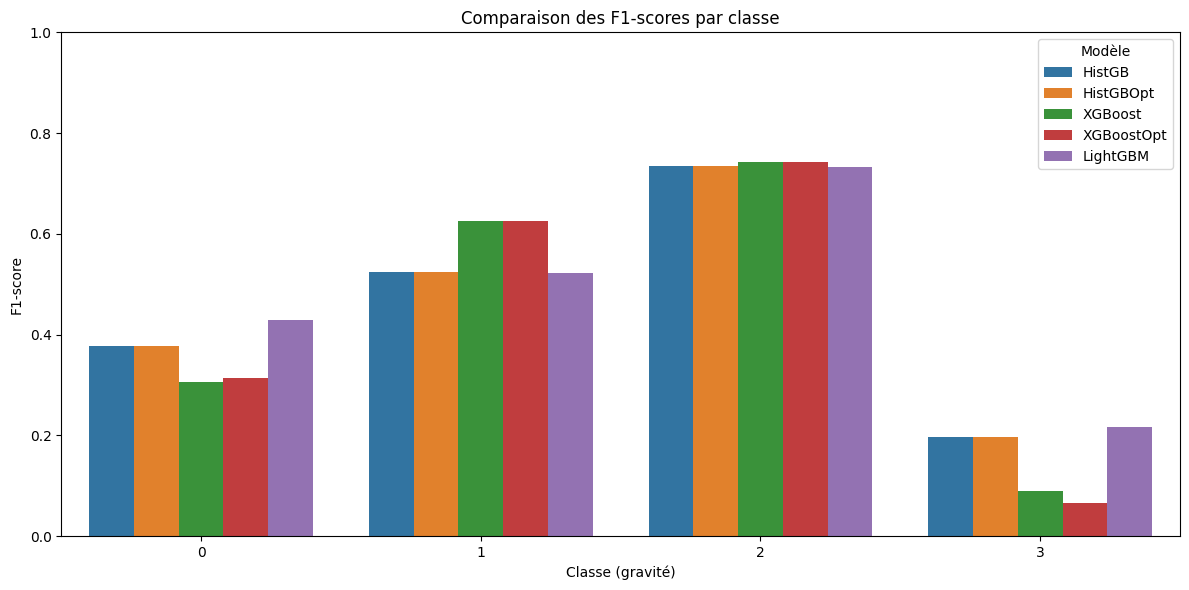

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_all[df_all['index'].isin(['0', '1', '2', '3'])],
    x='index', y='f1-score', hue='model'
)
plt.title("Comparaison des F1-scores par classe")
plt.xlabel("Classe (gravité)")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.legend(title="Modèle")
plt.tight_layout()
plt.show()

In [17]:
models = {
    "HistGB": hist,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

In [18]:
results = []

for name, model in models.items():
    if name == "XGBoost" or name == "XGBoostOpt":
        test = X_test.values.astype(np.float32)
    elif name == "LightGBM":
        test = X_test_lgbm
    else:
        test = X_test
        
    y_pred = model.predict(test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "model": name,
        "macro avg": report["macro avg"]["f1-score"],
        "weighted avg": report["weighted avg"]["f1-score"]
    })

df_scores = pd.DataFrame(results).set_index("model")
print(df_scores)

          macro avg  weighted avg
model                            
HistGB     0.458047      0.580294
XGBoost    0.440914      0.610511
LightGBM   0.475830      0.587782


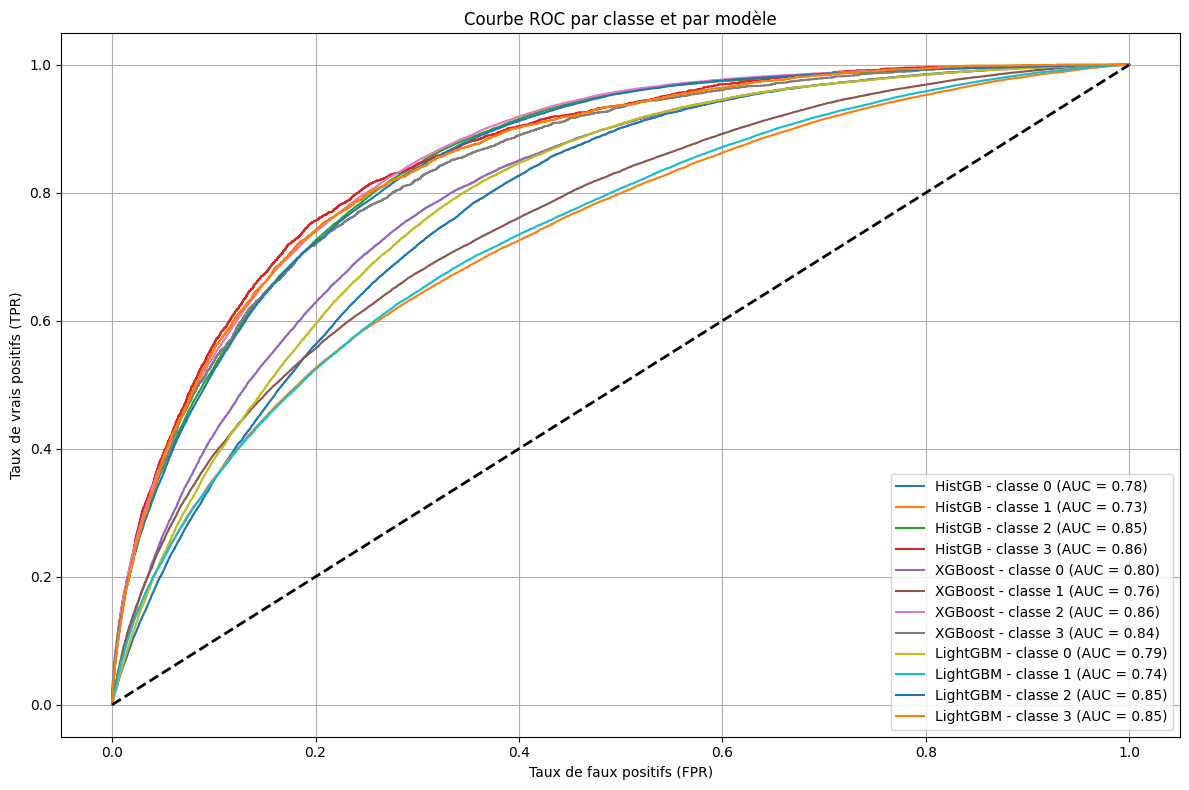

In [19]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(12, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        if name == "XGBoost" or name == "XGBoostOpt":
            X_test_data = X_test.values.astype(np.float32)
            y_score = model.predict_proba(X_test_data)
        elif name == "LightGBM":
            y_score = model.predict_proba(X_test_lgbm)
        else:
            y_score = model.predict_proba(X_test)
    else:
        y_score = model.predict_proba(X_test.to_numpy())

    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} - classe {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Courbe ROC par classe et par modèle")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

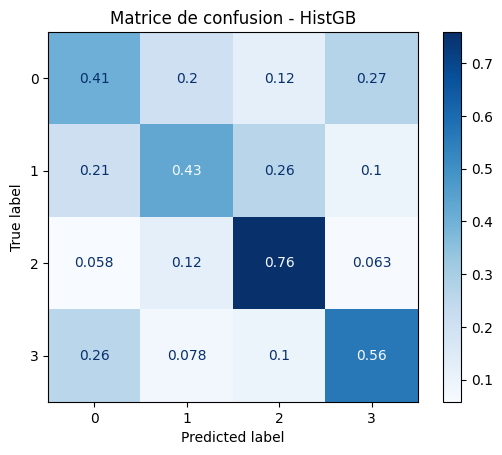

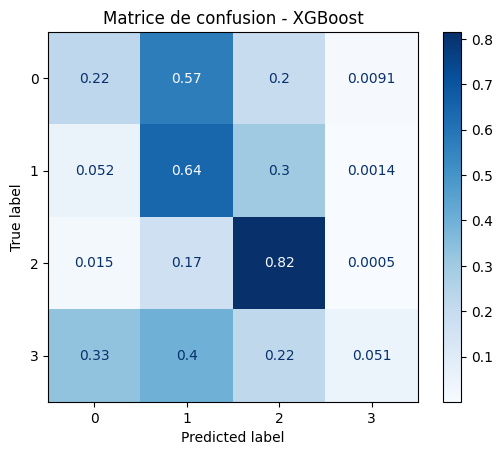

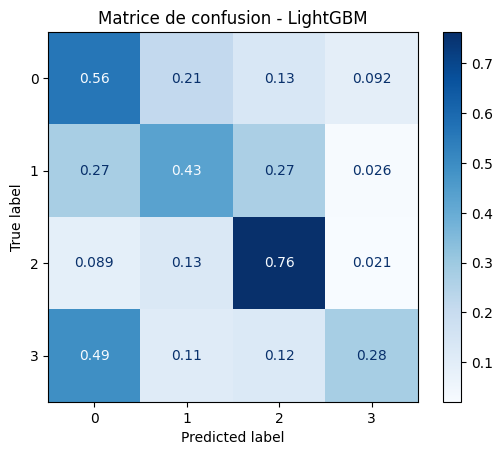

In [20]:
for name, model in models.items():
    if name == "XGBoost" or name == "XGBoostOpt":
        test = X_test.values.astype(np.float32)
    elif name == "LightGBM":
        test = X_test_lgbm
    else:
        test = X_test
    
    y_pred = model.predict(test)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"Matrice de confusion - {name}")
    plt.show()

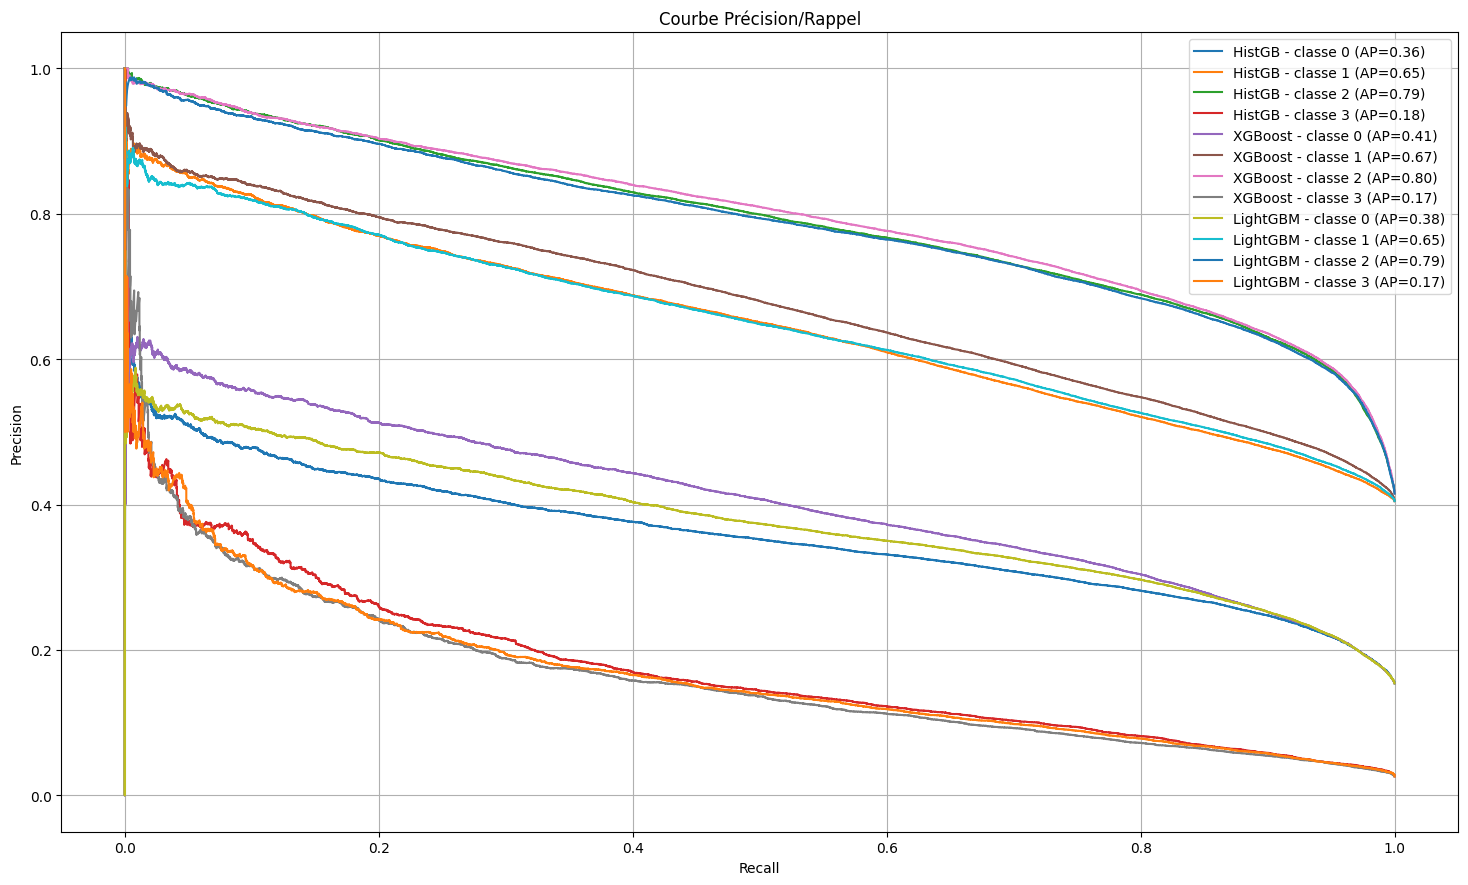

In [21]:
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        if name == "XGBoost" or name == "XGBoostOpt":
            X_test_data = X_test.values.astype(np.float32)
            y_score = model.predict_proba(X_test_data)
        elif name == "LightGBM":
            y_score = model.predict_proba(X_test_lgbm)
        else:
            y_score = model.predict_proba(X_test)
    else:
        y_score = model.predict_proba(X_test.to_numpy())
    
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f"{name} - classe {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision/Rappel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().set_size_inches(16, 10)
plt.show()


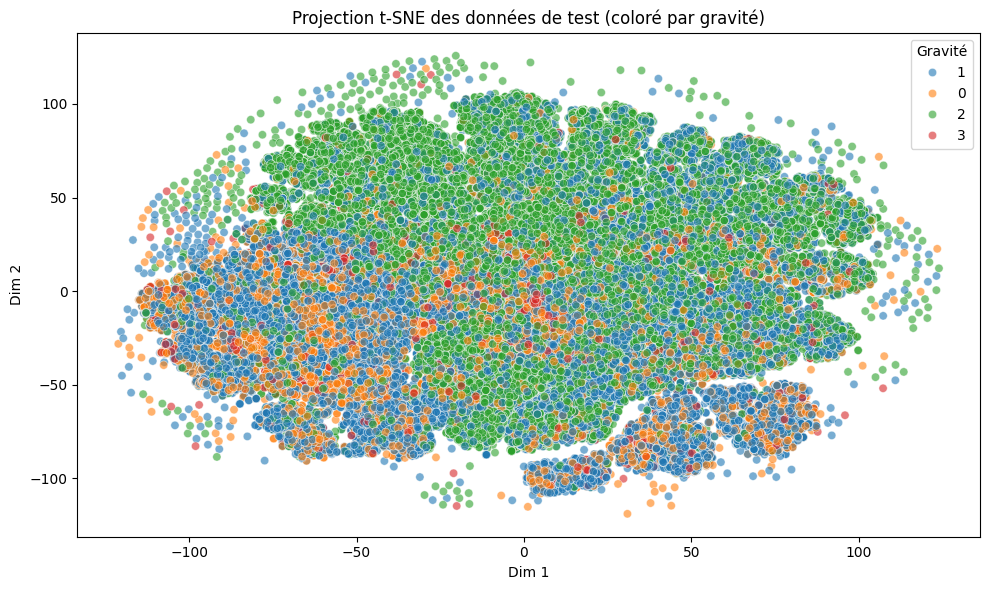

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_test)

df_tsne = pd.DataFrame(X_embedded, columns=["Dim 1", "Dim 2"])
df_tsne["gravité"] = y_test.astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="Dim 1", y="Dim 2", hue="gravité", palette="tab10", alpha=0.6)
plt.title("Projection t-SNE des données de test (coloré par gravité)")
plt.legend(title="Gravité")
plt.tight_layout()
plt.show()